# Week 4 Individual Assignment

Fonda Hu, UID: 605742970

Hello! In this notebook, we will explore any potential relationship between road conditions and the frequency of traffic collisions. 

Let's start with importing the necessary packages. 

In [1]:
import pandas as pd
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import shape
from shapely.geometry.polygon import Polygon
from shapely.geometry.linestring import LineString
from shapely.geometry.point import Point
import numpy as np


## ROAD SURFACE CONDITIONS

I found [data](https://data.lacity.org/City-Infrastructure-Service-Requests/Road-Surface-Condition-Map/d9rz-k88a) on road conditions in LA, updated by the Public Works department in December 2023. Let's check out this file.

In [2]:
df_condition = gpd.read_file('data/Road Surface Condition Map.zip')
df_condition.head()

from    pci  sect_id        st_name st_type status street_typ  \
0         83RD ST  78.09  5776100  WADSWORTH AVE   Local   Good         LO   
1       HOOVER ST  94.37  6773300       110TH ST   Local   Good         LO   
2  BLACKWELDER ST  36.00  1229900    COCHRAN AVE   Local   Poor         LO   
3        OBAMA BL  82.06  4363900    POTOMAC AVE   Local   Good         LO   
4        115TH ST  71.40  5149200    SUCCESS AVE   Local   Good         LO   

      surf1 surface               to  zlength  zwidth  \
0   Asphalt      AS          84TH ST    310.0    30.0   
1   Asphalt      AS  BARING CROSS ST    720.0    36.0   
2  Concrete      PC      HOMESIDE AV    290.0    30.0   
3   Asphalt      AS      COLISEUM ST   1175.0    34.0   
4   Asphalt      AS      IMPERIAL HY    270.0    40.0   

                                            geometry  
0  LINESTRING (-118.25858 33.96379, -118.25858 33...  
1  LINESTRING (-118.28694 33.93560, -118.28937 33...  
2  LINESTRING (-118.36035 34.02763, -118.36065 34...  
3  LINESTRING (-118.34420 34.02149, -118.34420 34...  
4  LINESTRING (-118.24927 33.93025, -118.24928 33...

Hm... the status, surface, and street type could be useful to look at. Let's see what unique values are contained within those fields.

In [3]:
print("Status Options: ")
status_list = df_condition.status.unique().tolist()
print(status_list)
print("Street Type Options: ")
streettype_list = df_condition.st_type.unique().tolist()
print(streettype_list)
print("Surface Options: ")
surf_list = df_condition.surf1.unique().tolist()
print(surf_list)

Status Options: 
['Good', 'Poor', 'Fair']
Street Type Options: 
['Local', 'Select']
Surface Options: 
['Asphalt', 'Concrete']


Breakdown of # of Streets in each category

In [4]:
print("Total # of Streets: " + str(df_condition.shape[0])  + "\n\nStatus")

for status in status_list:
    print(status + ": " + str(df_condition.loc[df_condition.status==status].shape[0]))

print("\n Street Type")
for streettype in streettype_list:
    print(streettype + ": " + str(df_condition.loc[df_condition.st_type==streettype].shape[0]))

print("\nSurface")
for surface in surf_list:
    print(surface + ": " + str(df_condition.loc[df_condition.surf1==surface].shape[0]))

Total # of Streets: 72563

Status
Good: 43974
Poor: 18195
Fair: 10394

 Street Type
Local: 51835
Select: 20728

Surface
Asphalt: 67794
Concrete: 4769


Let's merge these characteristics together

In [5]:
status_street_table = pd.DataFrame(index=status_list,columns=pd.MultiIndex.from_product([streettype_list,surf_list]))


for status in status_list:
    for streettype in streettype_list:
        for surface in surf_list:
            status_street_table.loc[status,(streettype,surface)] = df_condition.loc[(df_condition.status==status) & (df_condition.st_type==streettype) & (df_condition.surf1==surface)].shape[0]

pd.get_option('display.max_rows')
pd.get_option('display.max_columns')

status_street_table

Local           Select         
     Asphalt Concrete Asphalt Concrete
Good   33230      166   10407      171
Poor    8054     3462    6164      515
Fair    6584      339    3355      116

It seems like most of the local roads made of concrete are in poor condition. On the other hand, most roads made of asphalt and seem to be in good condition. Let's add another layer of data into this: road width and length.

In [6]:
#descriptive stats
print("Road Width")
print(df_condition["zwidth"].describe())

print("Road Length")
print(df_condition["zlength"].describe())

Road Width
count    72563.000000
mean        39.299106
std         14.159509
min          4.000000
25%         30.000000
50%         36.000000
75%         40.000000
max        136.000000
Name: zwidth, dtype: float64
Road Length
count    72563.000000
mean       520.293221
std        397.551759
min         20.000000
25%        300.000000
50%        375.000000
75%        660.000000
max       7985.000000
Name: zlength, dtype: float64


In [7]:
#Using CSV in order to increase data input to 43k, instead of API limit of 1000. 
tcd = pd.read_csv('Traffic_Collisions_2020_Fonda.csv')
tcd = tcd.head(10000)

In [8]:
#lets fix the spaces in the variable names, because it drives us nuts later! 
tcd.rename(columns={'old column name with spaces': 'new_column_name',
                    'Victim Age' : 'victim_age',
                    'Victim Sex' : 'victim_sex',
                    'Victim Descent' : 'victim_descent'
                   }, inplace=True)
tcd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   DR Number               10000 non-null  int64  
 1   Date Reported           10000 non-null  object 
 2   Date Occurred           10000 non-null  object 
 3   Time Occurred           10000 non-null  int64  
 4   Area ID                 10000 non-null  int64  
 5   Area Name               10000 non-null  object 
 6   Reporting District      10000 non-null  int64  
 7   Crime Code              10000 non-null  int64  
 8   Crime Code Description  10000 non-null  object 
 9   MO Codes                9510 non-null   object 
 10  victim_age              9423 non-null   float64
 11  victim_sex              9764 non-null   object 
 12  victim_descent          9745 non-null   object 
 13  Premise Code            9557 non-null   float64
 14  Premise Description     9557 non-null  

In [9]:
# convert df to gdf
# since data is in lat/lon's assign the crs to WGS84 (epsg:4326)
gtcd = gpd.GeoDataFrame(tcd, 
                       crs='epsg:4326',
                       geometry=gpd.points_from_xy(tcd.Longitude, tcd.Latitude))
gtcd.head(2)

DR Number Date Reported Date Occurred  Time Occurred  Area ID Area Name  \
0  200113538     6/17/2020     6/14/2020           2030        1   Central   
1  200518005    12/19/2020    12/19/2020           2205        5    Harbor   

   Reporting District  Crime Code Crime Code Description  \
0                 195         997      TRAFFIC COLLISION   
1                 514         997      TRAFFIC COLLISION   

                             MO Codes  victim_age victim_sex victim_descent  \
0  0605 3101 3401 3701 3006 3030 1501        31.0          F              H   
1            3036 3004 3026 3029 3101        39.0          F              H   

   Premise Code Premise Description Address Cross Street  Latitude  Longitude  \
0         101.0              STREET    15TH        MAPLE   34.0326  -118.2589   
1         101.0              STREET  LOMITA     FIGUEROA   33.7982  -118.2830   

                      geometry  
0  POINT (-118.25890 34.03260)  
1  POINT (-118.28300 33.79820)

In [10]:
#calculate the bounding box we're starting with
gtcd.drop(gtcd.loc[gtcd.Latitude==0].index,axis=0,inplace=True)

bbox = gtcd.total_bounds

#print the bounding box
print("Bounding Box:")
print("min Longitude:", bbox[0])
print("min Latitude:", bbox[1])
print("max Longitude:", bbox[2])
print("max Latitude:", bbox[3])

Bounding Box:
min Longitude: -118.6559
min Latitude: 33.7065
max Longitude: -118.1614
max Latitude: 34.3343


In [11]:
df_condition["geoshape"] = [shape(x) for x in df_condition.geometry.tolist()]
df_condition.geoshape
gtcd["geoshape"] = [shape(x) for x in gtcd.geometry.tolist()]

In [12]:
gtcd["street"] = ""

for street, sect_id in zip(df_condition.geoshape.values.tolist(),df_condition.sect_id.values.tolist()):
    gtcd.loc[street.distance(gtcd.geoshape)<1e-3,'street'] = sect_id
    

In [13]:
#gtcd_cond_street = gtcd[["street","Date Occurred"]].groupby(["street"],as_index=True)

In [14]:
gtcd_cond_street = gtcd["street"].value_counts()


In [15]:
#gtcd_cond_street.to_frame().sum(axis=1)

In [16]:
merged_df = df_condition.merge(gtcd_cond_street, left_on='sect_id', right_index=True, how='left')
merged_df

from    pci  sect_id        st_name st_type status  \
0             83RD ST  78.09  5776100  WADSWORTH AVE   Local   Good   
1           HOOVER ST  94.37  6773300       110TH ST   Local   Good   
2      BLACKWELDER ST  36.00  1229900    COCHRAN AVE   Local   Poor   
3            OBAMA BL  82.06  4363900    POTOMAC AVE   Local   Good   
4            115TH ST  71.40  5149200    SUCCESS AVE   Local   Good   
...               ...    ...      ...            ...     ...    ...   
72558       SUNSET BL  18.05  4484300        RENO ST   Local   Poor   
72559       SUNSET BL  18.05  4484300        RENO ST   Local   Poor   
72560       GEYSER AV  83.48  3713100     MIRANDA ST   Local   Good   
72561       GEYSER AV  83.48  3713100     MIRANDA ST   Local   Good   
72562         MARR ST  85.74  2691700      HOWARD ST   Local   Good   

      street_typ     surf1 surface               to  zlength  zwidth  \
0             LO   Asphalt      AS          84TH ST    310.0    30.0   
1             LO   Asphalt      AS  BARING CROSS ST    720.0    36.0   
2             LO  Concrete      PC      HOMESIDE AV    290.0    30.0   
3             LO   Asphalt      AS      COLISEUM ST   1175.0    34.0   
4             LO   Asphalt      AS      IMPERIAL HY    270.0    40.0   
...          ...       ...     ...              ...      ...     ...   
72558         LO  Concrete      PC     DEL MONTE DR    430.0    20.0   
72559         LO  Concrete      PC     DEL MONTE DR    430.0    20.0   
72560         LO   Asphalt      AS         CREBS AV    300.0    36.0   
72561         LO   Asphalt      AS         CREBS AV    300.0    36.0   
72562         LO   Asphalt      AS        OXFORD AV    490.0    40.0   

                                                geometry  \
0      LINESTRING (-118.25858 33.96379, -118.25858 33...   
1      LINESTRING (-118.28694 33.93560, -118.28937 33...   
2      LINESTRING (-118.36035 34.02763, -118.36065 34...   
3      LINESTRING (-118.34420 34.02149, -118.34420 34...   
4      LINESTRING (-118.24927 33.93025, -118.24928 33...   
...                                                  ...   
72558  LINESTRING (-118.27444 34.08231, -118.27420 34...   
72559  LINESTRING (-118.27415 34.08278, -118.27409 34...   
72560  LINESTRING (-118.54263 34.17568, -118.54303 34...   
72561  LINESTRING (-118.54303 34.17568, -118.54358 34...   
72562  LINESTRING (-118.45325 33.98620, -118.45322 33...   

                                                geoshape  count  
0      LINESTRING (-118.25857648065353 33.96378618833...    NaN  
1      LINESTRING (-118.28694473349576 33.93559844654...    NaN  
2      LINESTRING (-118.36035049621411 34.02762689581...    NaN  
3      LINESTRING (-118.34419638497438 34.02149410750...    NaN  
4      LINESTRING (-118.24926797298183 33.93025035439...    NaN  
...                                                  ...    ...  
72558  LINESTRING (-118.27444221941158 34.08231145616...    NaN  
72559  LINESTRING (-118.2741479835326 34.082783245886...    NaN  
72560  LINESTRING (-118.54263272129444 34.17567829795...    NaN  
72561  LINESTRING (-118.54303231744471 34.17567788117...    NaN  
72562  LINESTRING (-118.45324604384486 33.98619958602...    NaN  

[72563 rows x 15 columns]

In [17]:
merged_df = merged_df[~merged_df["count"].isna()]
merged_df

from    pci  sect_id          st_name st_type  \
293                     30TH ST  80.99  0110100          ALMA ST  Select   
787                  BEVERLY BL  92.49  4630500     ROSSMORE AVE  Select   
919                ALTA LOMA TE  68.18  2576100     HIGHLAND AVE  Select   
1080                 RUFFNER AV  65.10  5073500         STAGG ST   Local   
1253                 OSBORNE ST  39.94  2032500    FOOTHILL BLVD  Select   
...                         ...    ...      ...              ...     ...   
72552        PROMENADE PZ (PVT)  81.60  1039086        CENTER DR   Local   
72554  AVENUE 18/NORTH BROADWAY  95.11  3957400  NORTH SPRING ST  Select   
72555  AVENUE 18/NORTH BROADWAY  95.11  3957400  NORTH SPRING ST  Select   
72556                 SUNSET BL  66.68  5575600       VENDOME ST   Local   
72557                 SUNSET BL  66.68  5575600       VENDOME ST   Local   

      status street_typ    surf1 surface            to  zlength  zwidth  \
293     Good         SE  Asphalt      AS       37TH ST   2115.0    30.0   
787     Good         SE  Asphalt      AS  MUIRFIELD RD   1570.0    40.0   
919     Fair         SE  Asphalt      AS    CAMROSE DR    565.0    87.0   
1080    Fair         LO  Asphalt      AS     BALBOA BL   1300.0    44.0   
1253    Poor         SE  Asphalt      AS  GLADSTONE AV   3240.0    64.0   
...      ...        ...      ...     ...           ...      ...     ...   
72552   Good         LO  Asphalt      AS       PARK TE    710.0    35.0   
72554   Good         SE  Asphalt      AS     AURORA ST   1250.0    40.0   
72555   Good         SE  Asphalt      AS     AURORA ST   1250.0    40.0   
72556   Fair         LO  Asphalt      OV  DEL MONTE DR    460.0    48.0   
72557   Fair         LO  Asphalt      OV  DEL MONTE DR    460.0    48.0   

                                                geometry  \
293    LINESTRING (-118.30137 33.71473, -118.30145 33...   
787    LINESTRING (-118.32735 34.07303, -118.32737 34...   
919    LINESTRING (-118.33650 34.10914, -118.33639 34...   
1080   LINESTRING (-118.49691 34.21321, -118.49691 34...   
1253   LINESTRING (-118.37832 34.27602, -118.37837 34...   
...                                                  ...   
72552  LINESTRING (-118.39076 33.97671, -118.39086 33...   
72554  LINESTRING (-118.22517 34.07045, -118.22295 34...   
72555  LINESTRING (-118.22295 34.07141, -118.22242 34...   
72556  LINESTRING (-118.27504 34.08308, -118.27477 34...   
72557  LINESTRING (-118.27477 34.08351, -118.27465 34...   

                                                geoshape  count  
293    LINESTRING (-118.30137164345447 33.71473352755...    1.0  
787    LINESTRING (-118.32735448400526 34.07302560706...    1.0  
919    LINESTRING (-118.3365042724219 34.109139799550...    3.0  
1080   LINESTRING (-118.49690654231614 34.21320729904...    2.0  
1253   LINESTRING (-118.37832141665736 34.27602036378...    1.0  
...                                                  ...    ...  
72552  LINESTRING (-118.39076154124821 33.97670531999...    1.0  
72554  LINESTRING (-118.22516686420789 34.07044522952...    2.0  
72555  LINESTRING (-118.22295130618545 34.07141055847...    2.0  
72556  LINESTRING (-118.27504155696604 34.08307561086...    1.0  
72557  LINESTRING (-118.27477111695552 34.08351014572...    1.0  

[6019 rows x 15 columns]

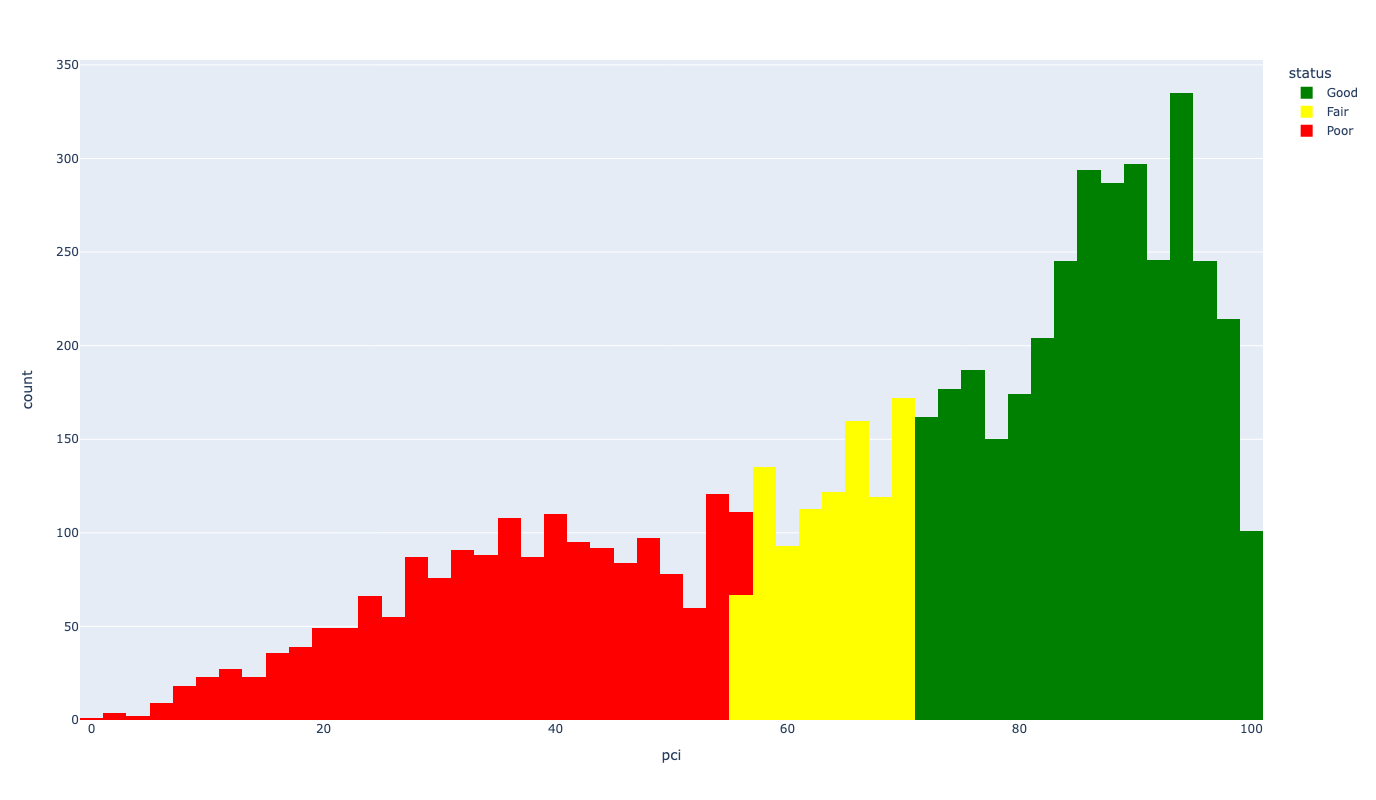

In [18]:
# x and y given as DataFrame columns
import plotly.express as px

fig = px.histogram(merged_df, x="pci",color="status",color_discrete_map={"Good":"green","Fair":"yellow","Poor":"red"},width=1200, height=800)
fig.show()

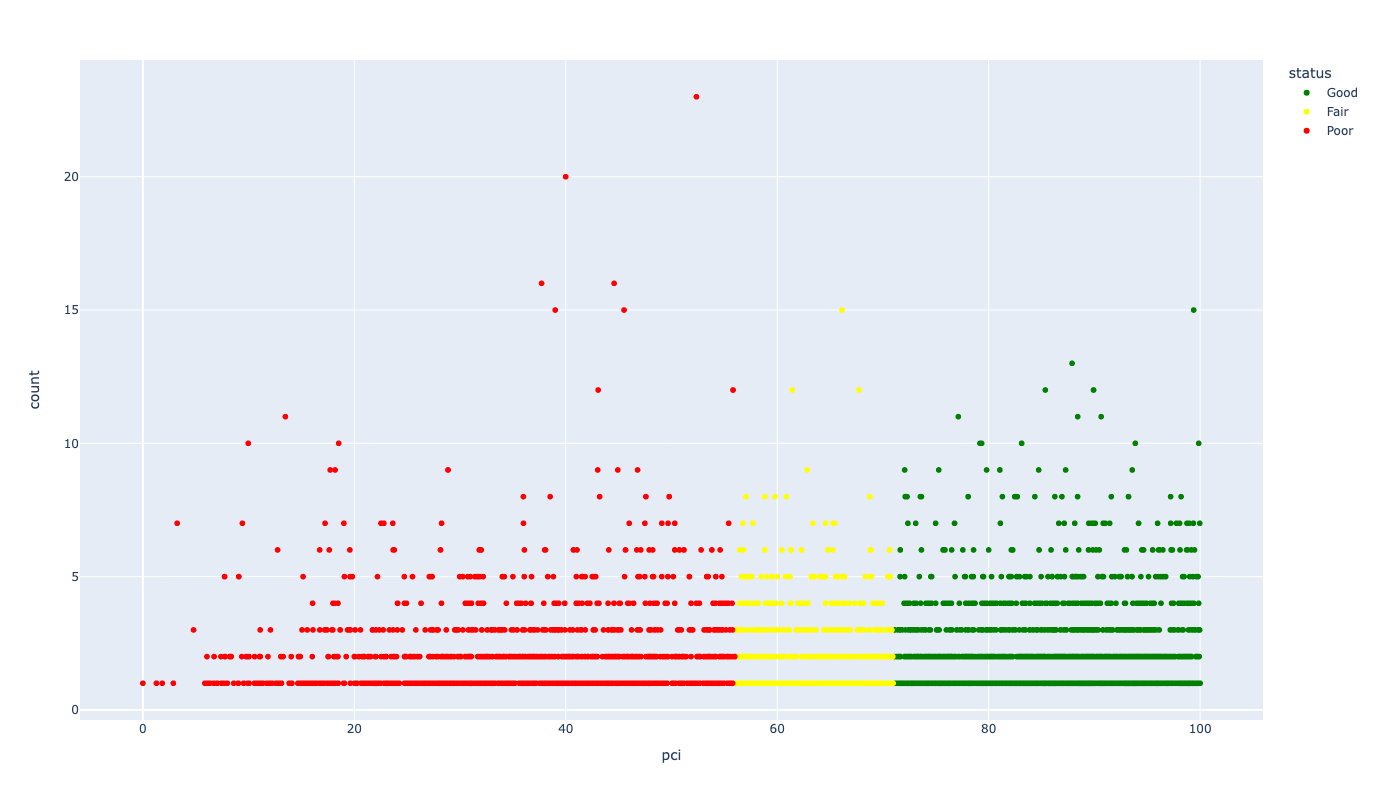

In [19]:
# x and y given as DataFrame columns
import plotly.express as px

fig = px.scatter(merged_df, x="pci", y="count",color="status",color_discrete_map={"Good":"green","Fair":"yellow","Poor":"red"},width=1200, height=800)
fig.show()

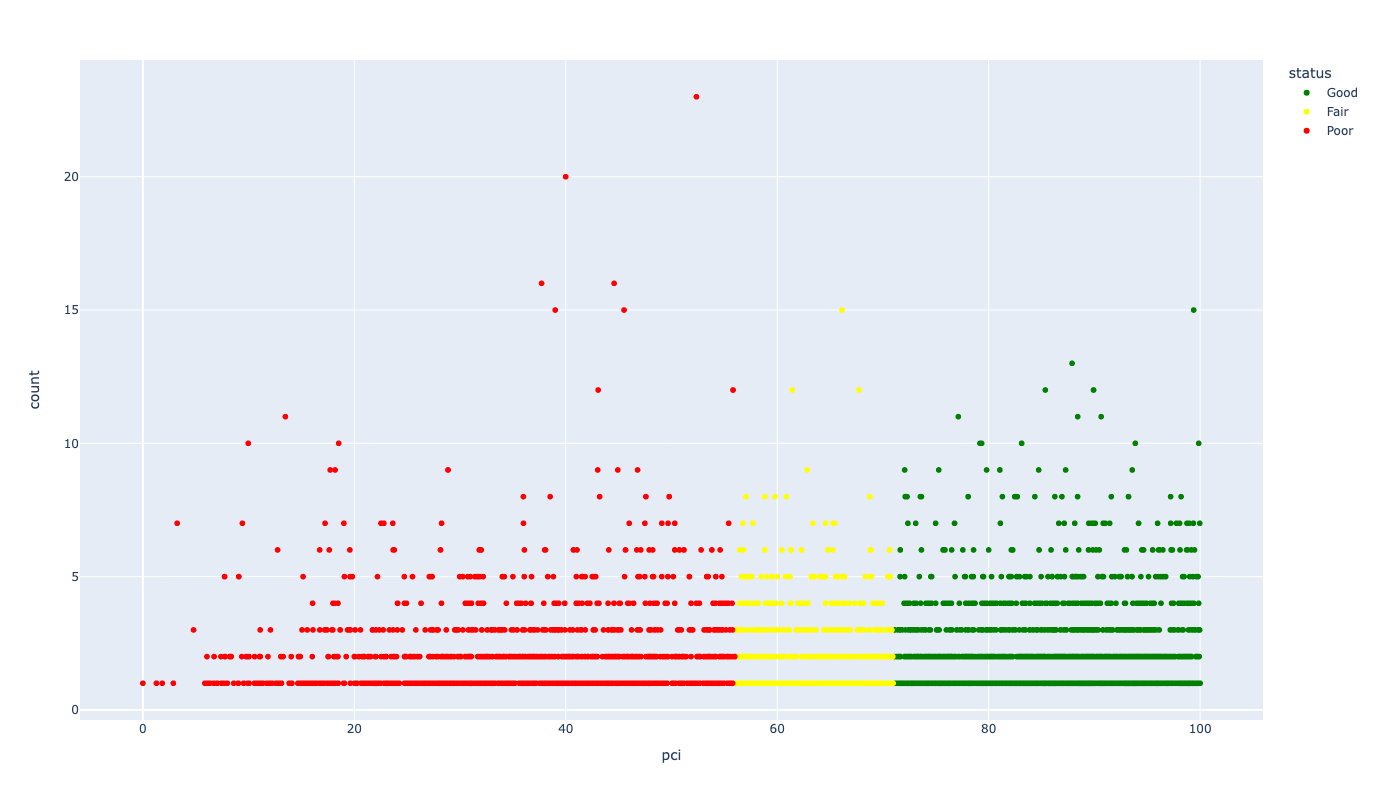

In [20]:
# x and y given as DataFrame columns
import plotly.express as px

fig = px.scatter(merged_df, x="pci", y="count",color="status",color_discrete_map={"Good":"green","Fair":"yellow","Poor":"red"},width=1200, height=800)
fig.show()

In [21]:
summ_stats = merged_df[["status","count"]].groupby(["status"]).sum()
print(summ_stats)
summ_stats/summ_stats["count"].sum()

         count
status        
Fair    1926.0
Good    6094.0
Poor    3523.0


count
status          
Fair    0.166854
Good    0.527939
Poor    0.305207

In [22]:
summ_stats = merged_df["status"].value_counts()
print(summ_stats)
summ_stats/summ_stats.sum()

status
Good    3318
Poor    1720
Fair     981
Name: count, dtype: int64


status
Good    0.551254
Poor    0.285762
Fair    0.162984
Name: count, dtype: float64

In [23]:
summ_stats = df_condition["status"].value_counts()
print(summ_stats)
summ_stats/summ_stats.sum()

status
Good    43974
Poor    18195
Fair    10394
Name: count, dtype: int64


status
Good    0.606011
Poor    0.250748
Fair    0.143241
Name: count, dtype: float64

In [24]:
# just concrete roads
summ_stats = merged_df[merged_df.surf1=="Concrete"]["status"].value_counts()
print(summ_stats)
summ_stats/summ_stats.sum()

status
Poor    282
Fair     40
Good     40
Name: count, dtype: int64


status
Poor    0.779006
Fair    0.110497
Good    0.110497
Name: count, dtype: float64

In [25]:
summ_stats = df_condition[df_condition.surf1=="Concrete"]["status"].value_counts()
print(summ_stats)
summ_stats/summ_stats.sum()

status
Poor    3977
Fair     455
Good     337
Name: count, dtype: int64


status
Poor    0.833927
Fair    0.095408
Good    0.070665
Name: count, dtype: float64

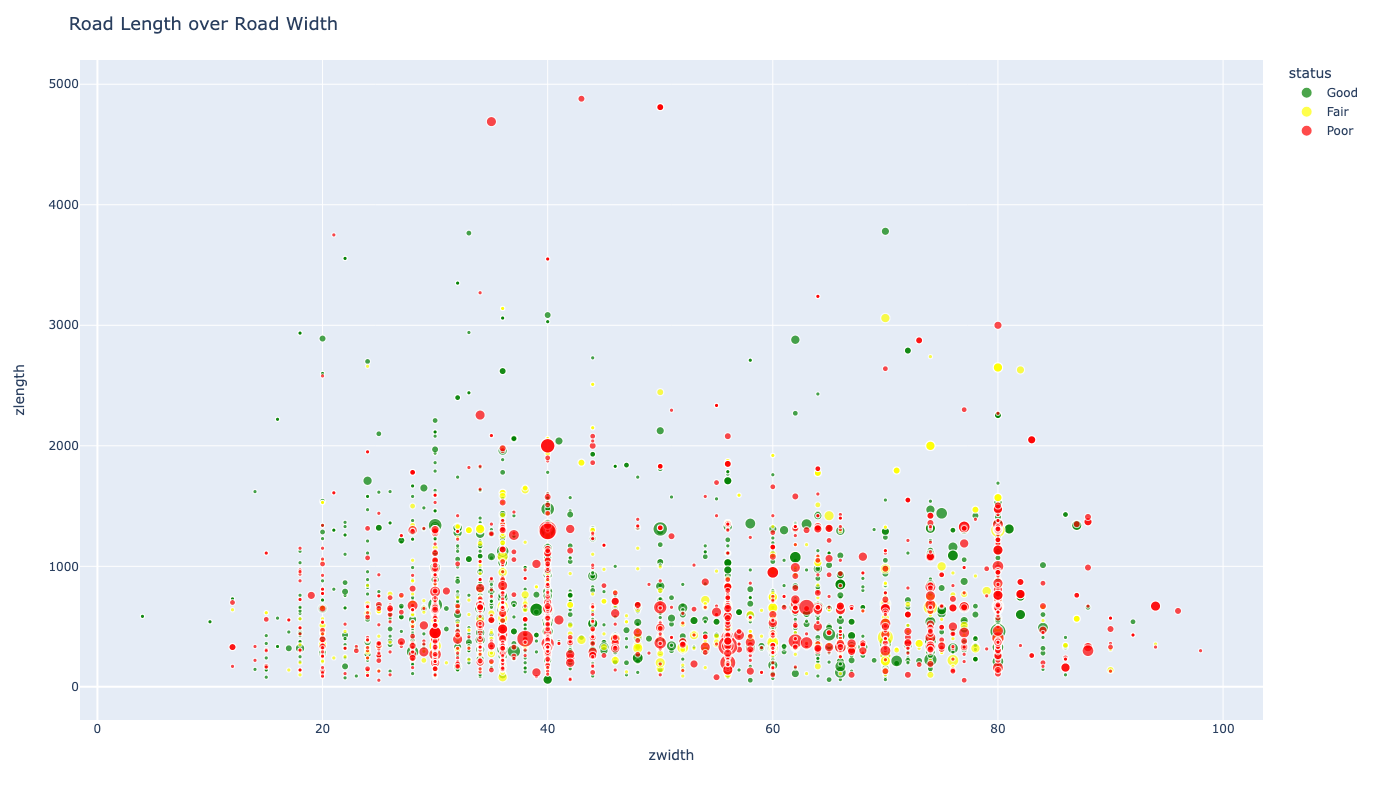

In [26]:
# x and y given as DataFrame columns
import plotly.express as px
trunc = merged_df[(merged_df.zlength<5000) & (merged_df.zwidth<100)]
fig = px.scatter(trunc, x="zwidth", y="zlength",color="status",size='count',color_discrete_map={"Poor":"red","Good":"green","Fair":"yellow"},width=1200, height=800)
fig.update_layout(title_text="Road Length over Road Width",
                  title_font_size=18)

fig.show()

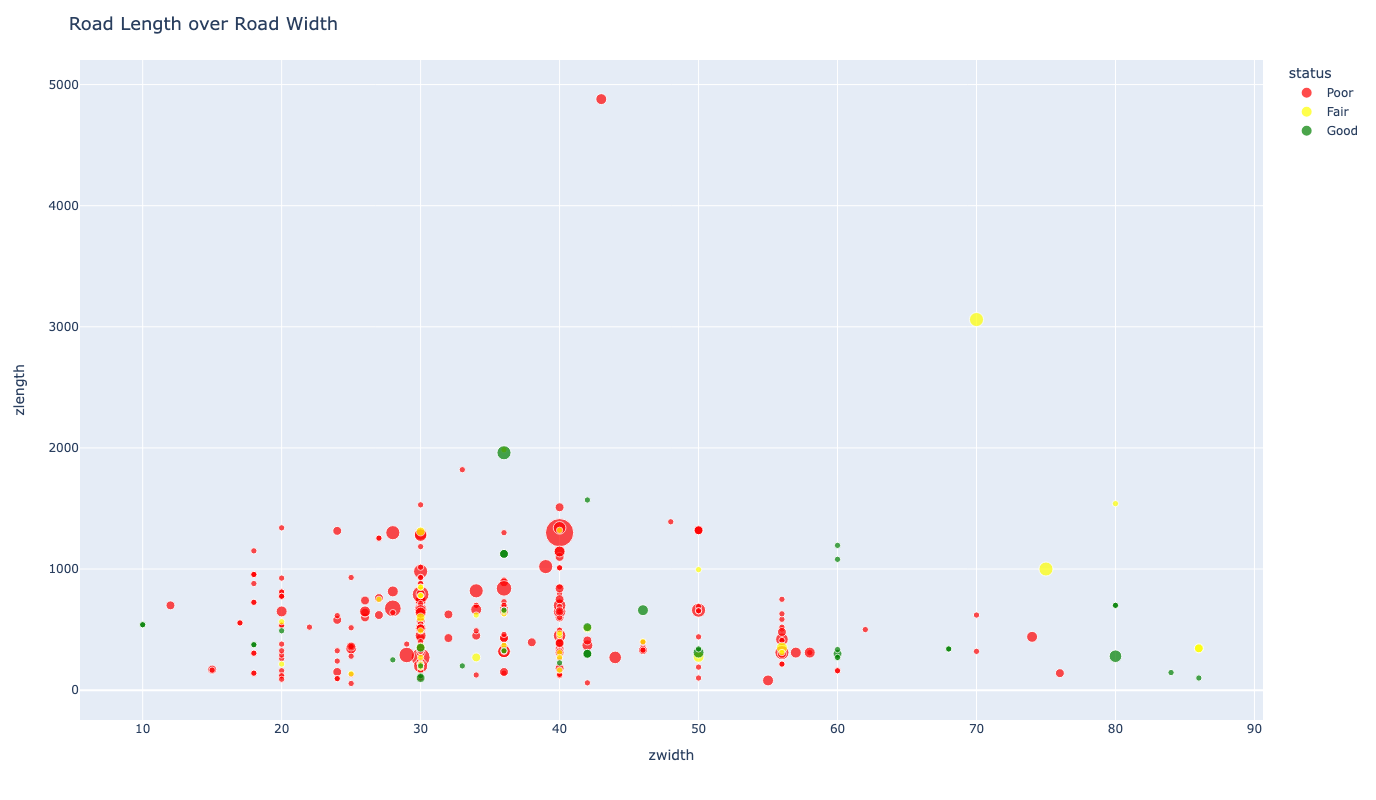

In [27]:
# x and y given as DataFrame columns
import plotly.express as px
trunc = merged_df[(merged_df.zlength<5000) & (merged_df.zwidth<100)& (merged_df.surf1 == "Concrete")]
fig = px.scatter(trunc, x="zwidth", y="zlength",color="status",size='count',color_discrete_map={"Poor":"red","Good":"green","Fair":"yellow"},width=1200, height=800)
fig.update_layout(title_text="Road Length over Road Width",
                  title_font_size=18)

fig.show()

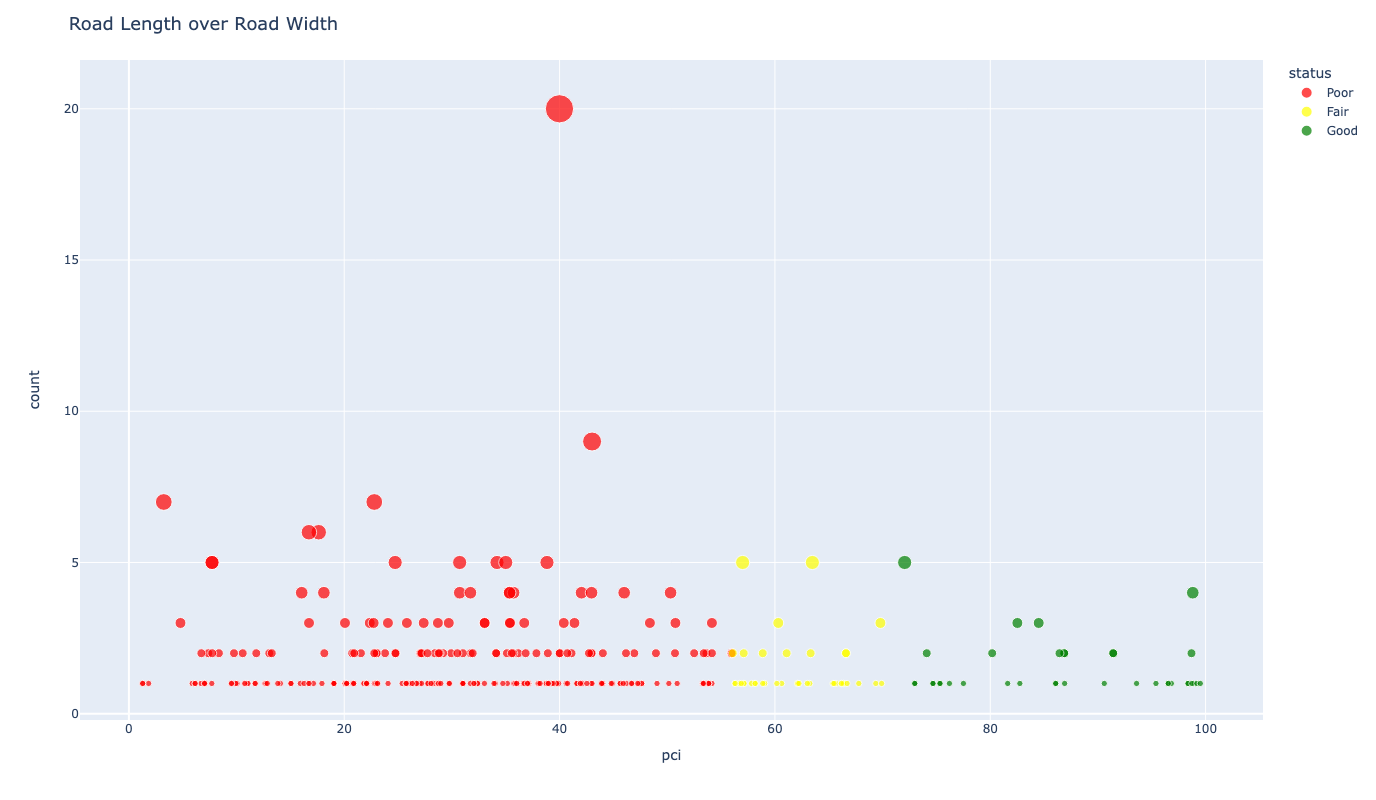

In [30]:
# x and y given as DataFrame columns
import plotly.express as px
trunc = merged_df[(merged_df.zlength<5000) & (merged_df.zwidth<100)& (merged_df.surf1 == "Concrete")]
fig = px.scatter(trunc, x="pci", y="count",color="status",size='count',color_discrete_map={"Poor":"red","Good":"green","Fair":"yellow"},width=1200, height=800)
fig.update_layout(title_text="Road Length over Road Width",
                  title_font_size=18)

fig.show()

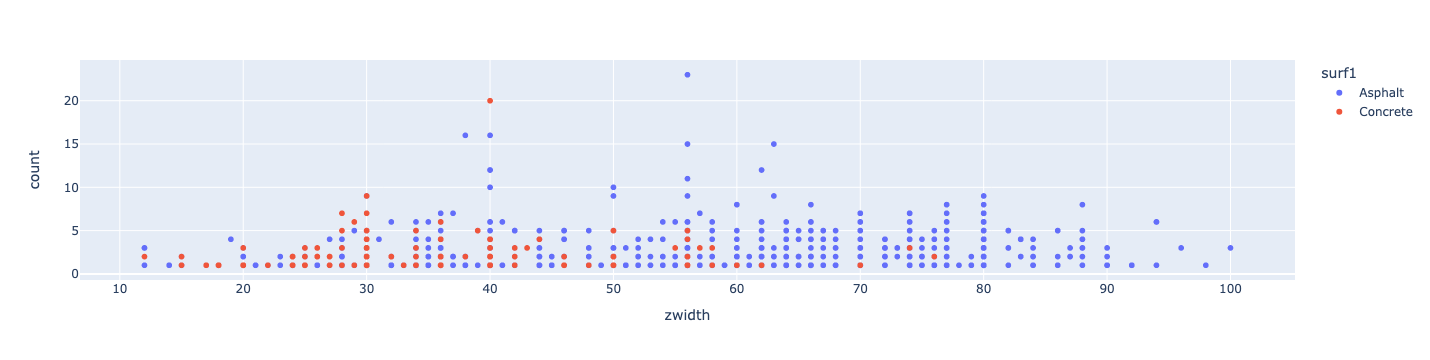

In [28]:
# x and y given as DataFrame columns
import plotly.express as px

fig = px.scatter(merged_df[merged_df["status"]=="Poor"], x="zwidth", y="count",color="surf1")
fig.show()

In [29]:
df_light = gpd.read_file("data/Streetlight locations.geojson")